<a href="https://colab.research.google.com/github/bezhvin/PyData2020-Eindhoven/blob/main/PyData_GAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the implemetation of Generative Adversarial Imputation Nets (GAIN) with tensorflow 2.x and Keras


In [ ]:
%tensorflow_version 2.x

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow.keras.backend as KB
from sklearn.metrics import mean_squared_error

In [ ]:
def plot(samples, strategy):
    fig = plt.figure(figsize = (5,5))
    gs = gridspec.GridSpec(5,5)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28,28))
    fig.suptitle(f'{strategy} imputation')    
    return fig

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
Dim = x_train.shape[1] * x_train.shape[2]
x_train=x_train.reshape((x_train.shape[0],Dim))
x_train = x_train / x_train.max()
x_test=x_test.reshape((x_test.shape[0],Dim))
x_test = x_test / x_test.max()
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

p_hint = 0.9
mb_size= 128
Train_No, D = x_train.shape

In [ ]:
def induce_missingness(data, p_missing=0.2):
  new_data= np.copy(data)
  A = np.random.uniform(0., 1., size = [data.shape[0], data.shape[1]])
  B = A < p_missing
  new_data[B] = np.nan
  return new_data

def make_noise_mask_hint(data, p_hint=0.9):
  # noise of the same size as data
  Z = np.random.uniform(0,1,[data.shape[0], data.shape[1]])
  #mask to show what element is missing
  mask = 1. * np.invert(np.isnan(data))
  # hint vector (refer to teh paper)
  A = np.random.uniform(0., 1., size = [data.shape[0], data.shape[1]])
  B = A > (1- p_hint)
  C = 1. * B
  hint = C * mask + (1-C) * 0.5
  return Z, mask, hint, C

x_train_miss = induce_missingness(x_train)
x_test_miss = induce_missingness(x_test)

noise_train, mask_train, hint_train, B_train = make_noise_mask_hint(x_train_miss)
noise_test, mask_test, hint_test, B_test = make_noise_mask_hint(x_test_miss)



Making generator and discriminator


In [ ]:
def make_generator(gen_inp_dim, gen_out_dim):
  generator = Sequential(name='generator')
  generator.add(Dense(units = 256, input_dim=gen_inp_dim, activation=tf.nn.leaky_relu ))
  generator.add(Dense(units = 128, activation=tf.nn.leaky_relu))
  generator.add(Dense(units=gen_out_dim, activation=tf.nn.sigmoid))
  return generator

def make_discriminator(disc_inp_dim, disc_out_dim):
  discriminator = Sequential(name='discriminator')
  discriminator.add(Dense(units = 256, input_dim=disc_inp_dim, activation=tf.nn.leaky_relu ))
  discriminator.add(Dense(units = 128, activation=tf.nn.leaky_relu))
  discriminator.add(Dense(units=disc_out_dim, activation=tf.nn.sigmoid))
  return discriminator

In [ ]:
# data pipeline
train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train,mask_train, noise_train,hint_train, B_train)).repeat(10).shuffle(Train_No).batch(mb_size)

In [ ]:
## generator imput:
def make_gen_inp(x,m, z):
  y =  m * x + (1-m) * z 
  return tf.concat([y,m], axis=-1)
## discriminator input
def make_disc_inp(x,m, g, h):
  y =  m * x + (1-m) * g 
  return tf.concat([y,h], axis=-1)

def initialize_models():
  g_in = make_gen_inp(x_train, mask_train, noise_train)
  generator = make_generator(g_in.shape[1],x_train.shape[1])
  g_out = generator(g_in)
  d_in = make_disc_inp(x_train, mask_train, g_out, hint_train)
  discriminator = make_discriminator(d_in.shape[1],hint_train.shape[1])
  return discriminator, generator

defining discriminator and generator loss function

In [ ]:
D_loss = lambda: -KB.mean((1.-b) * (m * KB.log(discriminator(disc_inp) + 1e-8) + (1.-m) * KB.log(1. - discriminator(disc_inp) + 1e-8))) ## cross entropy loss function for the discriminator
def G_loss(): # as explained in the paper
  g= generator(make_gen_inp(x,m,z))
  d= discriminator(make_disc_inp(x,m,g,h))
  loss1 = -KB.mean((1-b) * ((1-m) * KB.log(d + 1e-8))) / KB.mean(1-m) # discriminator assessment for missing elements
  loss2 =  KB.mean((m * x - m*g)**2) / KB.mean(m) ## MSE for observed elements
  return loss1 + alpha*loss2

In [ ]:
##
g_in = make_gen_inp(x_train, mask_train, noise_train)
g_in_test = make_gen_inp(x_test, mask_test, noise_test)
def calc_mse(generator, data =x_train ,g_in=g_in, mask = mask_train):
  g_out = generator(g_in)
  return np.mean(((mask * data - mask * g_out)**2)) / np.mean(mask)


discriminator, generator = initialize_models()

In [ ]:
theta_D = discriminator.trainable_weights
theta_G = generator.trainable_weights

In [ ]:
it=0
alpha=10; data=[]
train_mse_error = []; test_mse_error = []
Loss_D=[]; Loss_G=[]; Loss_C=[] ; error_test=[]; error_train=[]
for x, y, m, z,h,b in train_data:
  it = it + 1 
  z,m,h,b = tf.dtypes.cast((z,m,h,b), dtype=tf.float32)
  x = tf.image.convert_image_dtype(x, dtype=tf.float32)
  ## making generator input:
  gen_inp = make_gen_inp(x,m,z)
  g = generator(gen_inp)
  ## making discriminator input
  disc_inp = make_disc_inp(x,m,g,h)
  ## train discriminator on the current batch
  Loss_D.append(D_loss().numpy())
  D_solver = tf.keras.optimizers.Adam().minimize(loss = D_loss, var_list=theta_D)

  ## train the generator
  Loss_G.append(G_loss().numpy())
  G_solver = tf.keras.optimizers.Adam().minimize(loss = G_loss, var_list=theta_G)


  if it % 500 == 0:
    err = calc_mse(generator)
    print(f"at iteration {it} training error is {err}")
    train_mse_error.append(err)
    err_test = calc_mse(generator,data=x_test, g_in=g_in_test, mask=mask_test)
    print(f"at iteration {it} test error is {err_test}")
    test_mse_error.append(err_test)
    data.append(generator(tf.expand_dims(g_in[0], axis=0)))
    print(f"--------------")


at iteration 500 training error is 0.04041484594765816
at iteration 500 test error is 0.03993903892859098
--------------
at iteration 1000 training error is 0.03238366534959992
at iteration 1000 test error is 0.03200863990972338
--------------
at iteration 1500 training error is 0.02732580007683858
at iteration 1500 test error is 0.026981852685412894
--------------
at iteration 2000 training error is 0.024588651569562504
at iteration 2000 test error is 0.024151397560310338
--------------
at iteration 2500 training error is 0.023163042668474708
at iteration 2500 test error is 0.022874476915058086
--------------
at iteration 3000 training error is 0.022721175785995147
at iteration 3000 test error is 0.022461525756845842
--------------
at iteration 3500 training error is 0.02116546208891635
at iteration 3500 test error is 0.02092838565132078
--------------
at iteration 4000 training error is 0.019461208706941093
at iteration 4000 test error is 0.01932738186835353
--------------
at iterati

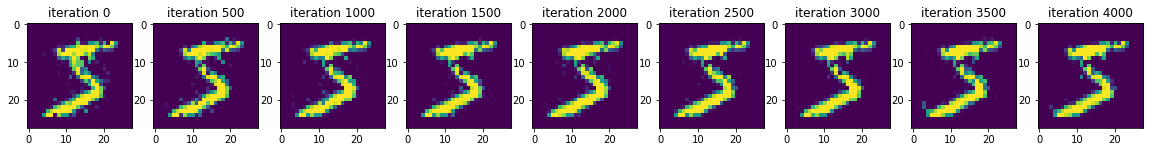

In [ ]:
fig, ax = plt.subplots(1,9, figsize=(20,10))
for i , j in enumerate(range(0,len(data))):
  image = mask_train[0] * x_train[0] + (1-mask_train[0]) * data[j]
  image = np.reshape(image,(28,28))
  ax[i].imshow(image)
  ax[i].set_title(f'iteration {j*500}')

MSE for test data : 0.020754582270914583


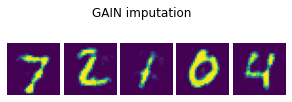

In [ ]:
x_test_imputed = generator(g_in_test)
print(f"MSE for test data : {mean_squared_error(x_test_imputed, x_test)}")
fig = plot(x_test_imputed.numpy()[0:5], f'GAIN') ## plotting 5 images after imputation